# **1. Görüntü İşleme 2021/2022 Proje 2** - **Emotion Detection from Human Faces**



*   05170000022 - Mehmet Anıl TAYSİ
*   05180000087 - Emel KAYACI



### **1.1 Verinin çekilmesi**

> Veriyi colab'da etkin kullanabilmek için drive üzerinden çekeceğiz. Bunu sağlamak adına öncelikle colabı yetkilendirme işlemleri yapmamız gerekiyor. Dosyamız bir .csv (comma separated values) dosyasıdır ve içerisinde duygu durumu, görüntüleri oluşturacak pixel değerleri (görüntüler 48x48 piksel olarak tanımlanmıştır) ve kullanım tipi (training ya da test) olarak sınıflandırılmıştır.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':"1O2lyVmCRJsV7esai2Bs4u8ha-ZF95hJb"})   
downloaded.GetContentFile('fer2013.csv')

Bu kısma kadar google drive üzerinden veriye ulaşmış oluyoruz. Şimdi bir fonksiyon tanımlayıp .csv'de bulunan piksel verilerinden görüntüleri oluşturup, labellarını tanımlayacağız. Yani model için kullanılacak verisetini oluşturmuş olacağız.

In [4]:
labels = ['Kızgın', 'Igrenmis', 'Korkmus', 'Mutlu', 'Uzgun', 'Sasirmis', 'Notr']
sutunlar = ['Duygu', 'pikseller', 'model_kullanim']

df = pd.read_csv('fer2013.csv', names= sutunlar, na_filter=False)
df = df.drop(0)
df.head(10)

,Duygu,pikseller,model_kullanim
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
10,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


Göründüğü üzere DataFrame'i oluşturduk. Sütunları da ifade ettiği verilere göre düzenledik.

In [5]:
def setOlustur(dataframe):
  X = []
  Y = []

  for index, satir in dataframe.iterrows():
    Y.append(int(satir['Duygu']))
    X.append([int(p) for p in satir['pikseller'].split()])

  X, Y = np.array(X) / 255.0, np.array(Y)
  return X, Y

Şimdi verimiz hakkındaki genel bilgilere bakalım. Aşağıdaki X listesi görüntü piksellerini tutar. X listesinden ayrıca veri setimizde 35887 adet resim bulunduğunu görebiliriz. Y ise projemizde mevcut olacak 7 adet duygu durumunu simgeler. 

In [6]:
X, Y = setOlustur(df)
duygu_sayisi = len(set(Y))
print("Duygu sayısı: ", duygu_sayisi)
print("Toplam veri sayısı: ", len(X))

Duygu sayısı:  7
Toplam veri sayısı:  35887


Her bir duygunun dağılımı aşağıda verilmiştir.

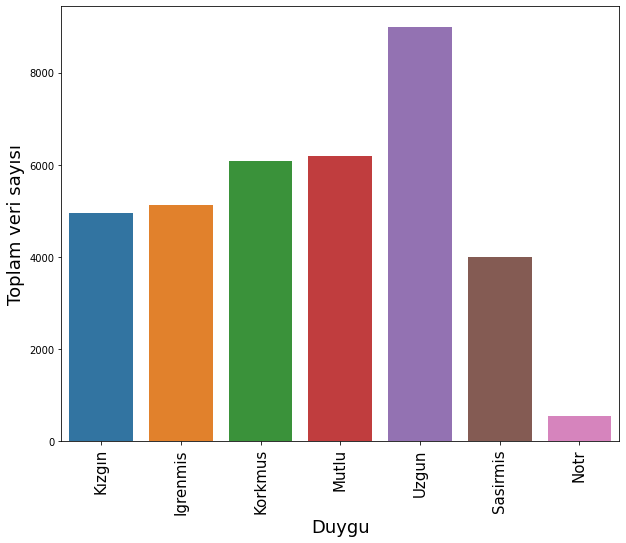

In [7]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x=df['Duygu'], data=df)
ax.set_xlabel('Duygu', fontsize=18)
ax.set_ylabel('Toplam veri sayısı', fontsize=18)
ax.set_xticklabels(labels, rotation='vertical', fontsize=15)
plt.show()

### **1.2 Gerekli kütüphanelerin import edilmesi**

In [8]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import backend as K

In [9]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

## **1.3 Eğitim ve test veri setinin ayrılması**

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(duygu_sayisi) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(duygu_sayisi) == y_test[:, None]).astype(np.float32)

Eğitim veri setimizdeki bazı örneklere bakalım.

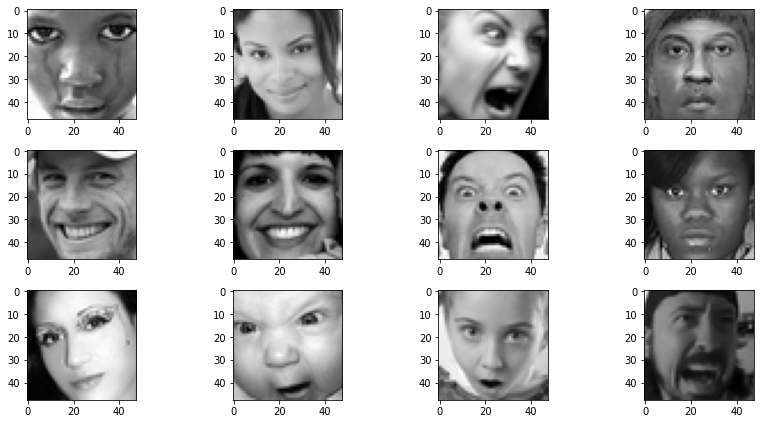

In [11]:
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(X_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

# **2. CNN Modeli**



## 2.1 Modelin kurulması

Öncelikle kullanacağımız kütüphaneleri collab dosyasına dahil etmemiz gerekmektedir. Modelimizi kurarken Keras kütüphanesinden yararlandık.

In [12]:
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from keras.layers import BatchNormalization

Modelimizi kurarken aşağıdaki özellikleri tercih ettik fakat bu özellikler rastgele belirlenmiş olup alt başlıklarda modelimizi optimize ettiğimizde değişecektir.

**Katman sayısı:** Konvolüsyon (Conv2D) katmanlarında 8, ilk Dense katmanında 16 olarak belirlendi.

**Katman miktarı:** Aşağıdaki modelde bir blok konvolüsyon katmanı bulunmaktadır. 

**Filtre boyutu:** Filtreler resimde çeşitli özelliklerin taranmasını sağlarlar. Bu özellikler dikey veya yatay çizgiler olabilir. Filtrelerin boyutları 2x2, 3x3, 4x4 gibi kare matris oluşturacak şekilde değerler alır. 

2x2 ve 4x4 filtrelerin kullanılması tercih edilmez çünkü simetrik bir dağılım göstermezler.

Deneme aşamasında 3x3 ve 5x5 filtrelerini karşılaştıracağız.

**Dropout oranı:** Dropout eğitim sırasında aşırı öğrenmeyi (overfit) engellemek için bazı nöronların işleme dahil edilmemesi demektir. Oranı da ne kadar nöronu işleme dahil etmediğimizi belirtir. İlk modelimizde oran 0.2'dir. 

**Not:** Dropout yalnızca Dense katmanından sonra değil konvolüsyon katmanlarından sonra da yapılabilir. Fakat konvolüsyon katmanlarında overfitting durumunu önlemek için BatchNormalization tercih edilmektedir.

Bunun nedeni dropout tekniğinin konvolüsyon katmanlarında daha az etkili olmasındandır. 

**Optimizer:** Optimizer yapay sinir ağlarında weight ve learning rate parametrelerini değiştirip loss değerlerini azaltmayı hedefleyen algoritmalardır. Bu algoritmalardan bazıları aşağıda verilmiştir.


1.   Gradient Descent
2.   Stochastic Gradient Descent (SGD)
3.   Mini Batch Stochastic Gradient Descent (MB-SGD)
4.   Adam
5.   AdaDelta
6.   RMSprop
7.   Adaptive Gradient (AdaGrad)

**Aktivasyon fonksiyonu:** Girdi değerlerine göre yapay sinir ağındaki nöronların üreteceği çıktı değerini belirleyen fonksiyonlardır. Aşağıdaki örnekte relu kullanılmıştır. 

**Padding:** Resmimizin boyutunu ayarlamamızı sağlar. Konvolüsyon katmanlarında uygulanan filtreler sonucu resmin boyutu küçülmektedir. Resmin boyutunu arttırmak için padding işlemi uygulanır. Aşağıda padding türleri verilmiştir.

1. Valid (No) Padding: Padding işlemi hiç gerçekleşmez. Resim filtre boyutuna oranla küçülür.
2. Same (Zero) Padding: Output ile input boyutunun aynı olmasını sağlar.
3. Constant Padding: 2. seçenekteki padding türü resmin etrafına piksel değerlerini 0 olarak eklerken burada kullanıcı istediği padding değerini yerleştirebilir.

Padding işlemi hiç olmazsa resim her bir konvolüsyon katmanından sonra daha çok küçülür ve artık özellik çıkartılamayacak hale gelir, bu nedenle same (zero) padding kullanılması tercih edilmiştir. (Bu parametrede herhangi bir değişiklik yapılmayacaktır.)

**Loss fonksiyonu:** Loss değerlerinin hesaplandığı fonksiyondur. Aşağıdaki örnekte categorical_crossentropy kullanılmıştır. Bizim örneğimiz de sınıflandırma işlemi yaptığından ve sınıflandırmalarda en başarılı loss fonksiyonu bu olduğundan denemelerde bu parametreyi dikkate almayacağız.

**EĞİTİM AŞAMASINDA DEĞİŞTİRİLEBİLECEK HİPERPARAMETRELER**

**Batch size:** Model parametrelerini güncellemeden önce üzerinde çalışılacak örnek sayısını tanımlayan bir hiperparametredir.

**Epoch:** Öğrenme algoritmasının tüm eğitim veri kümesi boyunca çalışacağı sayıyı tanımlayan bir hiperparametredir.

Bir epoch, eğitim veri kümesindeki her örneğin dahili model parametrelerini güncelleme fırsatına sahip olduğu anlamına gelir.



In [13]:
def cnn_model(num_layers, filter_size, activation_func, dropout, optimizer, block_number):
    model = Sequential()
    input_shape = (48,48,1)

    for i in range(block_number):
      model.add(Conv2D(num_layers, filter_size, input_shape=input_shape,activation=activation_func, padding='same'))
      model.add(Conv2D(num_layers, filter_size, activation=activation_func, padding="same"))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Activation(activation_func))
    model.add(Dropout(dropout))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model
model=cnn_model(8, (5,5), 'relu', 0.2, 'Adam', 1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         208       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 8)         1608      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 16)                7

In [14]:
epoch_num = 8

In [15]:
def cnn_model_fit():
  K.set_value(model.optimizer.lr,1e-3) # set the learning rate
  # fit the model
  history_cnn=model.fit(x=X_train,     
              y=y_train, 
              batch_size=64, 
              epochs=epoch_num, 
              verbose=1, 
              validation_data=(X_test,y_test),
              shuffle=True)
  return history_cnn

## 2.2 Katman sayısını arttırmak

In [ ]:
history_8_layers=cnn_model_fit()

Epoch 1/8
505/505 [==============================] - 19s 6ms/step - loss: 1.6504 - accuracy: 0.3540 - val_loss: 1.7834 - val_accuracy: 0.3611
Epoch 2/8
505/505 [==============================] - 3s 5ms/step - loss: 1.4357 - accuracy: 0.4476 - val_loss: 1.4309 - val_accuracy: 0.4550
Epoch 3/8
505/505 [==============================] - 3s 5ms/step - loss: 1.3487 - accuracy: 0.4835 - val_loss: 1.4828 - val_accuracy: 0.4244
Epoch 4/8
505/505 [==============================] - 3s 5ms/step - loss: 1.2876 - accuracy: 0.5065 - val_loss: 1.4146 - val_accuracy: 0.4564
Epoch 5/8
505/505 [==============================] - 3s 5ms/step - loss: 1.2298 - accuracy: 0.5274 - val_loss: 1.3869 - val_accuracy: 0.4831
Epoch 6/8
505/505 [==============================] - 3s 5ms/step - loss: 1.1864 - accuracy: 0.5433 - val_loss: 1.3722 - val_accuracy: 0.4840
Epoch 7/8
505/505 [==============================] - 3s 5ms/step - loss: 1.1429 - accuracy: 0.5612 - val_loss: 1.4042 - val_accuracy: 0.4929
Epoch 8/8
50

### 2.2.1 32 katman

In [ ]:
model=cnn_model(32, (5,5), 'relu', 0.2, 'Adam', 1)
model.summary()
history_32_layers=cnn_model_fit()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        832       
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 16)               

### 2.2.2 128 katman

In [ ]:
model=cnn_model(128, (5,5), 'relu', 0.2, 'Adam', 1)
model.summary()
history_128_layers=cnn_model_fit()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 128)       3328      
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_4 (Dense)             (None, 16)               

### 2.2.3 Yorum

Katman sayısı arttıkça öğrenilecek parametre sayısı da artmaktadır. Parametreler veri içindeki benzer desenleri keşfedebilmeyi sağlarlar. Daha çok parametre ile daha benzer desenlerin keşfedilmesi kolaylaşır. İşlem süresi artsa da grafikten de görüldüğü üzere hem train hem de validation setlerinin accuracy değerleri artmıştır. 

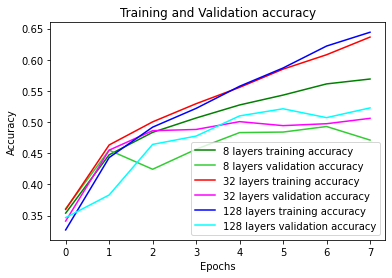

In [ ]:
x=range(epoch_num)

accuracy_8 = history_8_layers.history['accuracy']
val_accuracy_8 = history_8_layers.history['val_accuracy']

accuracy_32 = history_32_layers.history['accuracy']
val_accuracy_32 = history_32_layers.history['val_accuracy']

accuracy_128 = history_128_layers.history['accuracy']
val_accuracy_128 = history_128_layers.history['val_accuracy']

plt.plot(x, accuracy_8, 'green', label='8 layers training accuracy')
plt.plot(x, val_accuracy_8, 'limegreen', label='8 layers validation accuracy')


plt.plot(x, accuracy_32, 'r', label='32 layers training accuracy')
plt.plot(x, val_accuracy_32, 'magenta', label='32 layers validation accuracy')

plt.plot(x, accuracy_128, 'b', label='128 layers training accuracy')
plt.plot(x, val_accuracy_128, 'cyan', label='128 layers validation accuracy')


plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2.3 Katman miktarını arttırmak

### 2.3.1 2 blok katman

In [ ]:
model=cnn_model(128, (5,5), 'relu', 0.2, 'Adam', 2)
model.summary()
history_2_block=cnn_model_fit()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 128)       3328      
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)       409728    
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

### 2.3.2 3 blok katman

In [ ]:
model=cnn_model(128, (5,5), 'relu', 0.2, 'Adam', 3)
model.summary()
history_3_block=cnn_model_fit()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 128)       409728    
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)      

### 2.3.3 Yorum

Blok sayısı arttıkça eğitilecek parametre sayısı da artacağından daha başarılı sonuçlar elde edilmiştir. 

Ayrıca yeşil ile gösterilmiş eğriler 2.1.3 maddesinde en yüksek başarıya sahip eğrilerken (2.1.3 maddesinde mavi ile gösterilmişlerdi) burada en düşük başarıya sahiptirler. 

Artık modelimize 3 bloklu yapıdan devam edip başarıyı arttırmaya çalışabiliriz.

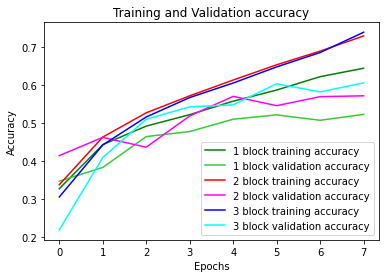

In [ ]:
accuracy_1 = history_128_layers.history['accuracy']
val_accuracy_1 = history_128_layers.history['val_accuracy']

accuracy_2 = history_2_block.history['accuracy']
val_accuracy_2 = history_2_block.history['val_accuracy']

accuracy_3 = history_3_block.history['accuracy']
val_accuracy_3 = history_3_block.history['val_accuracy']

plt.plot(x, accuracy_1, 'green', label='1 block training accuracy')
plt.plot(x, val_accuracy_1, 'limegreen', label='1 block validation accuracy')


plt.plot(x, accuracy_2, 'r', label='2 block training accuracy')
plt.plot(x, val_accuracy_2, 'magenta', label='2 block validation accuracy')

plt.plot(x, accuracy_3, 'b', label='3 block training accuracy')
plt.plot(x, val_accuracy_3, 'cyan', label='3 block validation accuracy')


plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2.4 Filtre boyutu

### 2.4.1 3x3 filtre

In [ ]:
model=cnn_model(128, (3,3), 'relu', 0.2, 'Adam', 3)
model.summary()
history_3_filter=cnn_model_fit()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 128)       1280      
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 batch_normalization_13 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 128)       147584    
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 128)      

### 2.4.2 7x7 filtre

In [ ]:
model=cnn_model(128, (7,7), 'relu',  0.2, 'Adam', 3)
model.summary()
history_7_filter=cnn_model_fit()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 48, 48, 128)       6400      
                                                                 
 conv2d_23 (Conv2D)          (None, 48, 48, 128)       802944    
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 24, 24, 128)       802944    
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 128)      

### 2.4.3 Yorum

Filtrelerin boyutu, temel özelliklerin bulunmasında önemli bir rol oynar. Daha büyük boyutlu bir filtre, önemli özellikleri gözden kaçırabilir ve görüntülerdeki temel ayrıntıları atlayabilirken, daha küçük boyutlu bir filtre daha fazla bilgi sağlayarak daha fazla kafa karışıklığına neden olabilir. Bu nedenle, filtrenin en uygun boyutunun belirlenmesine ihtiyaç vardır. Filtre boyutu model ve çalışılan verisetine bağlı oldukça değişken bir yapı göstermektedir fakat genellikle 3x3 filtreler tercih edilmektedir. Bunun nedeni de merkez ve çevresindeki birim her bir pikseli tarıyor olmasındadır. 

Bizim projemizde 7x7 boyutlu filtre en kötü sonucu verirken 5x5 filtre ile en iyi sonucu elde ettik. Hem eğitim hem de test verisinde 5x5 filtre en iyi sonucu verdiğinden modelimizi kurmaya bu filtre ile devam edeceğiz.

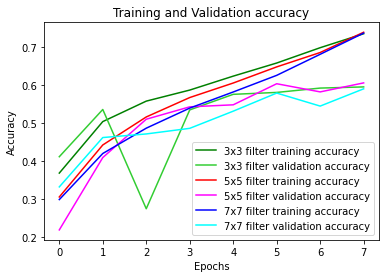

In [ ]:
accuracy_3 = history_3_filter.history['accuracy']
val_accuracy_3 = history_3_filter.history['val_accuracy']

accuracy_5 = history_3_block.history['accuracy']
val_accuracy_5 = history_3_block.history['val_accuracy']

accuracy_7 = history_7_filter.history['accuracy']
val_accuracy_7 = history_7_filter.history['val_accuracy']

plt.plot(x, accuracy_3, 'green', label='3x3 filter training accuracy')
plt.plot(x, val_accuracy_3, 'limegreen', label='3x3 filter validation accuracy')


plt.plot(x, accuracy_5, 'r', label='5x5 filter training accuracy')
plt.plot(x, val_accuracy_5, 'magenta', label='5x5 filter validation accuracy')

plt.plot(x, accuracy_7, 'b', label='7x7 filter training accuracy')
plt.plot(x, val_accuracy_7, 'cyan', label='7x7 filter validation accuracy')


plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2.5 Dropout oranı

### 2.5.1 0.01 oran

In [ ]:
model=cnn_model(128, (5,5), 'relu',  0.01, 'Adam', 3)
model.summary()
history_dropout_1=cnn_model_fit()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 conv2d_29 (Conv2D)          (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_21 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 24, 24, 128)       409728    
                                                                 
 conv2d_31 (Conv2D)          (None, 24, 24, 128)      

### 2.5.2 0.1 oran

In [ ]:
model=cnn_model(128, (5,5), 'relu',  0.1, 'Adam', 3)
model.summary()
history_dropout_2=cnn_model_fit()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 conv2d_35 (Conv2D)          (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_25 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 24, 24, 128)       409728    
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 128)      

### 2.5.3 0.3 oran

In [ ]:
model=cnn_model(128, (5,5), 'relu',  0.3, 'Adam', 3)
model.summary()
history_dropout_3=cnn_model_fit()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 conv2d_41 (Conv2D)          (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_29 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 24, 24, 128)       409728    
                                                                 
 conv2d_43 (Conv2D)          (None, 24, 24, 128)      

### 2.5.4 Yorum

Dropout ve BatchNormalization gibi yapılar overfit durumunu önlemeyi amaçlar. Bizim modelimizde de overfit durumu geçerlidir çünkü modelimiz eğitim verisinde iyi başarı oranı elde ederken, epoch sayısı artarsa %90 oranına bile çıkarken, test verisinde %60 üstüne çıkmamaktadır.

Dropout oranı azaldıkça eğitim esnasında daha az nöron atılır ve bu nedenle model veriyi daha iyi öğrenip, ezberlemeye yaklaşır. 

Modelimizin test verisinde dropout oranının kayda değer bir etkisi bulunmamıştır bu nedenle 0.2 oranı kullanılmaya devam edilecektir.

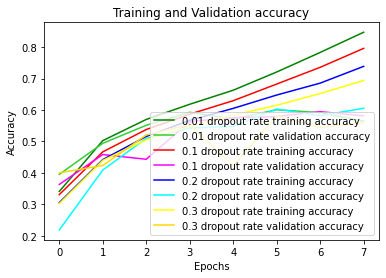

In [ ]:
accuracy_1 = history_dropout_1.history['accuracy']
val_accuracy_1 = history_dropout_1.history['val_accuracy']

accuracy_2 = history_dropout_2.history['accuracy']
val_accuracy_2 = history_dropout_2.history['val_accuracy']

accuracy_3 = history_3_block.history['accuracy']
val_accuracy_3 = history_3_block.history['val_accuracy']


accuracy_4 = history_dropout_3.history['accuracy']
val_accuracy_4 = history_dropout_3.history['val_accuracy']

plt.plot(x, accuracy_1, 'green', label='0.01 dropout rate training accuracy')
plt.plot(x, val_accuracy_1, 'limegreen', label='0.01 dropout rate validation accuracy')


plt.plot(x, accuracy_2, 'r', label='0.1 dropout rate training accuracy')
plt.plot(x, val_accuracy_2, 'magenta', label='0.1 dropout rate validation accuracy')

plt.plot(x, accuracy_3, 'b', label='0.2 dropout rate training accuracy')
plt.plot(x, val_accuracy_3, 'cyan', label='0.2 dropout rate validation accuracy')

plt.plot(x, accuracy_4, 'yellow', label='0.3 dropout rate training accuracy')
plt.plot(x, val_accuracy_4, 'gold', label='0.3 dropout rate validation accuracy')


plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2.6 Optimizer fonksiyonu

### 2.6.1 Stochastic Gradient Descent (SGD)

In [ ]:
model=cnn_model(128, (5,5), 'relu', 0.2, 'SGD', 3)
model.summary()
history_sgd=cnn_model_fit()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 conv2d_47 (Conv2D)          (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_33 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 24, 24, 128)       409728    
                                                                 
 conv2d_49 (Conv2D)          (None, 24, 24, 128)     

### 2.6.2 Adadelta

In [ ]:
model=cnn_model(128, (5,5), 'relu', 0.2, 'Adadelta', 3)
model.summary()
history_adadelta=cnn_model_fit()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 conv2d_53 (Conv2D)          (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_37 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 24, 24, 128)       409728    
                                                                 
 conv2d_55 (Conv2D)          (None, 24, 24, 128)     

### 2.6.3 RMSprop

In [ ]:
model=cnn_model(128, (5,5), 'relu', 0.2, 'RMSprop', 3)
model.summary()
history_rmsprop=cnn_model_fit()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 conv2d_59 (Conv2D)          (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_41 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 24, 24, 128)       409728    
                                                                 
 conv2d_61 (Conv2D)          (None, 24, 24, 128)     

### 2.6.4 Adagrad

In [ ]:
model=cnn_model(128, (5,5), 'relu', 0.2, 'Adagrad', 3)
model.summary()
history_adagrad=cnn_model_fit()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 conv2d_65 (Conv2D)          (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_45 (Bat  (None, 48, 48, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 24, 24, 128)       409728    
                                                                 
 conv2d_67 (Conv2D)          (None, 24, 24, 128)     

KeyboardInterrupt: ignored

### 2.6.5 Yorum

Optimizasyon algoritmaları karşılaştırıldığında RMSprop veya Adam algoritmasının kullanılabileceği belirlenmiştir. 

Aradaki fark fazla olmadığından Adam algoritması kullanılmaya devam etmiştir ve model böylece tamamlanmıştır.

In [ ]:
accuracy_1 = history_sgd.history['accuracy']
val_accuracy_1 = history_sgd.history['val_accuracy']

accuracy_2 = history_adadelta.history['accuracy']
val_accuracy_2 = history_adadelta.history['val_accuracy']

accuracy_3 = history_rmsprop.history['accuracy']
val_accuracy_3 = history_rmsprop.history['val_accuracy']

accuracy_4 = history_adagrad.history['accuracy']
val_accuracy_4 = history_adagrad.history['val_accuracy']

accuracy_5 = history_3_block.history['accuracy']
val_accuracy_5 = history_3_block.history['val_accuracy']

plt.plot(x, accuracy_1, 'green', label='SGD optimizer accuracy')
plt.plot(x, val_accuracy_1, 'limegreen', label='SGD optimizer validation accuracy')

plt.plot(x, accuracy_2, 'r', label='Adadelta optimizer training accuracy')
plt.plot(x, val_accuracy_2, 'darkred', label='Adadelta optimizer validation accuracy')

plt.plot(x, accuracy_3, 'b', label='RMSprop optimizer training accuracy')
plt.plot(x, val_accuracy_3, 'cyan', label='RMSprop optimizer validation accuracy')

plt.plot(x, accuracy_4, 'yellow', label='Adagrad optimizer training accuracy')
plt.plot(x, val_accuracy_4, 'gold', label='Adagrad optimizer validation accuracy')

plt.plot(x, accuracy_5, 'orchid', label='Adam optimizer training accuracy')
plt.plot(x, val_accuracy_5, 'plum', label='Adam optimizer validation accuracy')


plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **3. Modelin Son Hali**

Yalnızca bu aşamadan sonraki kısımları görmek için direkt 2.1 kısmı ile bu kısım çalıştırılabilir.

2.2 ile 2.6 kısımları deneysel çalışmalar olup ana amaç modeli en iyi parametreleri kullanarak kurmaktır.

In [16]:
model=cnn_model(128, (5,5), 'relu', 0.2, 'Adam', 3)
model.summary()
cnn_model_fit()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       3328      
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 128)       409728    
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 128)       409728    
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

# **4. Model Başarılarının Yorumlanması**


In [ ]:
preds = model.predict(X_test, verbose=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
print("Accuracy score: ",accuracy_score(y_test, np.round_(preds)))
print("Classification report:")
print(classification_report(y_test, np.round_(preds)))

Şimdi test sınıfımızdan herhangi bir resmin görüntüsüne bakıp modelimizin bu görüntüyü hangi sınıfa yerleştirdiğine bakalım.

In [ ]:
def resim_siniflandir(number):
  img_no = number #image number range(0,8972)
  img = X_test[img_no].reshape(48,48)
  plt.figure()
  plt.title(labels[np.argmax(preds[img_no])])
  plt.imshow(img, cmap='gray')
  plt.show()

In [ ]:
resim_siniflandir(75)

In [ ]:
resim_siniflandir(30)

In [ ]:
resim_siniflandir(3)

In [ ]:
resim_siniflandir(4)

In [ ]:
resim_siniflandir(15)

In [ ]:
resim_siniflandir(6)

#**5. Gerçek Zamanlı Yüz İfadesi Tahmini**

In [17]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import PIL
import io
import html
import time

In [18]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [19]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [20]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [27]:

video_stream()

label_html = 'Capturing...'
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray,1.1,4)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      roi_gray = gray[y:y+h, x:x+w]
      roi_color = img[y:y+h, x:x+w]
      cv2.rectangle( img, (x,y), (x+w, y+h), (255,0,0), 2)
      facess = face_cascade.detectMultiScale(roi_gray)
      if(len(facess)==0):
        print("no face detected")
      else:
        for (ex,ey,ew,eh) in facess:
          face_roi = roi_gray[ey: ey+eh, ex: ex + ew]
        #prediction phase
        final_image = cv2.resize(face_roi, (48,48))
        final_image = np.expand_dims(final_image, axis=0) #fourth dimension
        final_image = final_image/255.0
        font = cv2.FONT_HERSHEY_SIMPLEX
        Predictions = model.predict(final_image)
        font_scale = 1.5
        font = cv2.FONT_HERSHEY_PLAIN

        if(np.argmax(Predictions)==0):
          status = "Angry"
          
          x1,y1,w1,h1 = x,y,175,75
          cv2.rectangle(bbox_array, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
          #text
          cv2.putText(bbox_array, status, (x1+ int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
          #cv2.putText(bbox_array, status, (100,150), font, 3, (0,0,255),2,cv2.LINE_4)

          cv2.rectangle(bbox_array, (x,y), (x+w, y+h), (0,0,255))

        elif(np.argmax(Predictions)==1):
          status = "Igrenmis"
          
          x1,y1,w1,h1 = x,y,175,75
          cv2.rectangle(bbox_array, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
          #text
          cv2.putText(bbox_array, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
          #cv2.putText(bbox_array, status, (100,150), font, 3, (0,0,255),2,cv2.LINE_4)

          cv2.rectangle(bbox_array, (x,y), (x+w, y+h), (0,0,255))   
        elif(np.argmax(Predictions)==2):
          status = "korkmus"
          
          x1,y1,w1,h1 = x,y,175,75
          cv2.rectangle(bbox_array, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
          #text
          cv2.putText(bbox_array, status, (x1+ int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
          #cv2.putText(bbox_array, status, (100,150), font, 3, (0,0,255),2,cv2.LINE_4)

          cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255))   
        elif(np.argmax(Predictions)==3):
          status = "Mutlu"
          
          x1,y1,w1,h1 = x,y,175,75
          cv2.rectangle(bbox_array, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
          #text
          cv2.putText(bbox_array, status, (x1+ int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
          #cv2.putText(bbox_array, status, (100,150), font, 3, (0,0,255),2,cv2.LINE_4)

          cv2.rectangle(bbox_array, (x,y), (x+w, y+h), (0,0,255))   
        elif(np.argmax(Predictions)==4):
          status = "uzgun"
          
          x1,y1,w1,h1 = x,y,175,75
          cv2.rectangle(bbox_array, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
          #text
          cv2.putText(bbox_array, status, (x1+ int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
          #cv2.putText(bbox_array, status, (100,150), font, 3, (0,0,255),2,cv2.LINE_4)

          cv2.rectangle(bbox_array, (x,y), (x+w, y+h), (0,0,255))   
        elif(np.argmax(Predictions)==5):
          status = "sasirmis"
          
          x1,y1,w1,h1 = x,y,175,75
          cv2.rectangle(bbox_array, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
          #text
          cv2.putText(bbox_array, status, (x1+ int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
          #cv2.putText(bbox_array, status, (100,150), font, 3, (0,0,255),2,cv2.LINE_4)

          cv2.rectangle(bbox_array, (x,y), (x+w, y+h), (0,0,255))   
        elif(np.argmax(Predictions)==6):
          status = "notr"
          
          x1,y1,w1,h1 = x,y,175,75
          cv2.rectangle(bbox_array, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
          #text
          cv2.putText(bbox_array, status, (x1+ int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
          #cv2.putText(bbox_array, status, (100,150), font, 3, (0,0,255),2,cv2.LINE_4)

          cv2.rectangle(bbox_array, (x,y), (x+w, y+h), (0,0,255)) 
        
        
      

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

no face detected
no face detected


# **6. Kullanılan kütüphane ve versiyonları**

Başka kullanıcıların da projeyi çalıştırabilmesi için kütüphane ve versiyonlar requirements.txt dosyası içinde bulunmaktadır.

In [ ]:
from pip._internal.utils.misc import get_installed_distributions
import sys
#import numpy as np # imported to test whether numpy shows up, which it does!

def get_imported_packages():
    p = get_installed_distributions()
    p = {package.key:package.version for package in p}

    imported_modules = set(sys.modules.keys())
    
    imported_modules.remove('pip')

    modules = [(m, p[m]) for m in imported_modules if p.get(m, False)]

    return modules


def generate_requirements(filepath:str, modules):
    with open(filepath, 'w') as f:
        for module, version in modules:
            f.write(f"{module}=={version}")


generate_requirements('requirements.txt', get_imported_packages())

# 7. Model Şeması

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras

In [ ]:
import visualkeras
from PIL import ImageFont
font_type = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font_type)  # font is optional!